# Music machine learning - Adversarial learning

### Author: Philippe Esling (esling@ircam.fr)

Generative adversarial networks (GANs) are neural networks that generate material, such as images, music, speech, or text, that is similar to what humans produce.

In this course we will cover
1. The global principle of [adversarial learning](#adversarial)
2. How to train your own GAN on a [toy dataset](#toy)
3. A practical example on [MNIST](#mnist) using PyTorch

<a id="adversarial"></a>
## Adversarial learning

This is the code used in first example of the article [Generative Adversarial Networks: Build Your First Models](https://realpython.com/generative-adversarial-networks/) on Real Python.

In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
#from helper_plot import hdr_plot_style
#hdr_plot_style()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Generative adversarial networks (GANs) are machine learning systems that can learn to mimic a given distribution of data. GANs consist of two neural networks, one trained to *generate* data and the other trained to *discriminate* fake data from real data (hence the “adversarial” nature of the model).

GANs require to define two neural networks, one called the *generator* and the other called the *discriminator*. The role of the generator is to estimate the probability distribution of the real samples in order to provide generated samples resembling real data. The discriminator, in turn, is trained to estimate the probability that a given sample came from the real data rather than being provided by the generator.

These two networks define a *zero-sum game* as they are trained to compete with each other: the generator tries to get better at fooling the discriminator, while the discriminator tries to get better at identifying generated samples.

## Training GANs on a toy dataset

To understand how GAN training works, consider a toy example with a dataset composed of two-dimensional samples $(x_{1}, x_{2})$, with $x_{1}$ in the interval from $0$ to $2\pi$ and $x_{2} = sin(x_{1})$, as illustrated in the following 

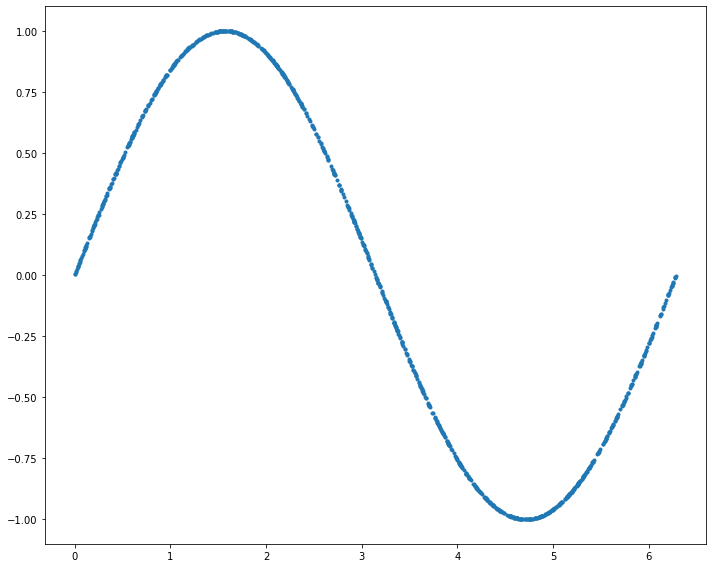

In [ ]:
train_data_length = 1024
train_data = torch.zeros((train_data_length,2))
train_data[:,0] = 2*math.pi*torch.rand(train_data_length)
train_data[:,1] = torch.sin(train_data[:,0])
train_labels = torch.zeros(train_data_length)
trainset = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
plt.figure(figsize=(10,8))
plt.plot(train_data[:, 0], train_data[:, 1], '.')
plt.tight_layout()

As usual, we need to define a `DataLoader` that will provide us with the training data in different batches.

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

First, we define the generator, which is fed with random data from a latent space. Its role is to generate data resembling the real samples. In this example, you have a two-dimensional latent space, so that the generator is fed with random $(z_{1}, z_{2})$ pairs and is required to transform them so that they resemble the real samples.

We can define any type of network in the generator, given that it has sufficient complexity to generate the underlying type of data.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),            
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
generator = Generator()

In turn, the discriminator is fed with either real samples from the training dataset or generated samples provided by the generator. Its role will be to estimate the probability that the input belongs to the real dataset or is a generated one. The training is performed so that the discriminator outputs 1 when it is fed a real sample and 0 when it is fed a generated sample. Again, we can choose any architecture of our liking for this network.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator()

We can now define our training hyper-parameters that will condition the learning procedure.

In [ ]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

The training procedure is defined as follows

In [ ]:
loss_d = torch.zeros(int(num_epochs / 10))
loss_g = torch.zeros(int(num_epochs / 10))

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        
        ######################
        ## Discriminator
        optimizer_discriminator.zero_grad()
        
        # Génération fake samples 
        noise = torch.randn(real_samples.size(0), 2)
        fake_samples = generator(noise) # Forward generator
        
        # Forward discriminator 
        real_output = discriminator(real_samples)
        fake_output = discriminator(fake_samples)
        desired_real_dis = torch.ones_like(real_output)
        desired_fake_dis = torch.zeros_like(fake_output)
        
        # Loss discriminator
        loss_discriminator = loss_function(torch.concat((real_output, fake_output)), torch.concat((desired_real_dis, desired_fake_dis)))
        # Gradient discrimator 
        loss_discriminator.backward()  
        
        # update discriminator
        optimizer_discriminator.step()
        
        
        ## Generator 
        optimizer_generator.zero_grad()
        
        # Loss generator
        fake_samples = generator(noise)
        fake_ouput = discriminator(fake_samples)
        #desired_gen = torch.ones_like(fake_output)
        loss_generator = loss_function(fake_ouput, torch.ones_like(fake_output),)
                                           
        # Gradient generator 
        loss_generator.backward()  
        
        # update generator
        optimizer_generator.step()
        
        ######################

    # Show loss
    if epoch % 10 == 0 and n == batch_size - 1:
        loss_d[int(epoch / 10)] = loss_discriminator
        loss_g[int(epoch / 10)] = loss_generator

If we look at the evolution of different losses, we can clearly see the competing nature of both networks

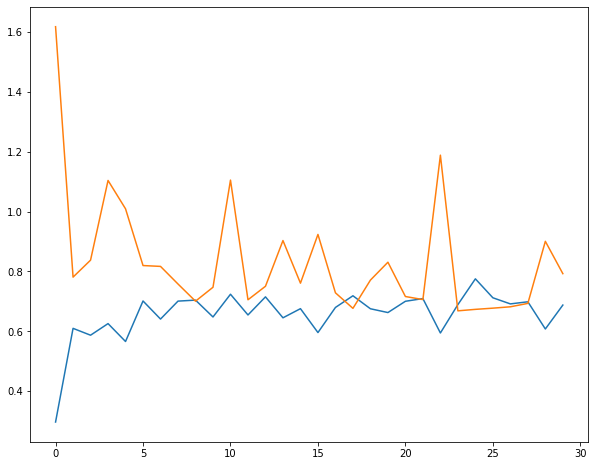

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(loss_d.detach())
plt.plot(loss_g.detach())

Now, we can visualize the samples that can be generated by drawing some random latent positions.

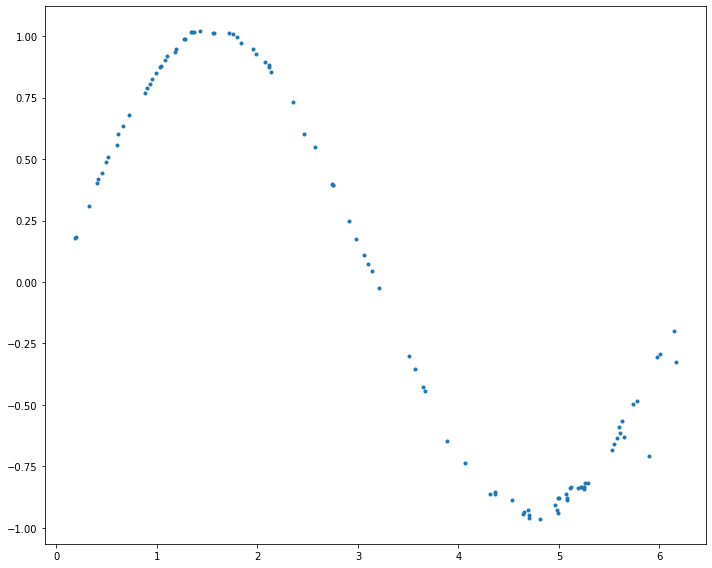

In [ ]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.figure(figsize=(10,8))
plt.plot(generated_samples[:,0], generated_samples[:,1], '.')
plt.tight_layout()

As we can see, the randomly generated points closely follow the original distribution.

## Handwritten digits generator with GAN

Generative adversarial networks can also generate high-dimensional samples such as images. In this example, we are going to define a GAN to generate images of handwritten digits. For that, we will train the models using the infamous MNIST dataset. 

Again, we are going to make use of `torch` and `torchvision` . Notably, we will use `transforms` to obtain the training data and perform image conversions.

In [ ]:
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os

Since this example uses images in the training set, the models need to be more complex, with a larger number of parameters. This makes the training process slower, taking about two minutes per epoch when running on CPU. To reduce the training time, you can use a GPU to train the model if you have one available. The following piece of code allows to automatically select the best device available on your system.

In [ ]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Preparing the training data

The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, we need to convert them to Tensors. Also, in order to ensure adequate learning, it is always best to normalize the data. This is were we make use of `torchvision.transforms` in order to perfom thesse automatically while loading the data.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

Now, as usual, we can load both the *training* and *testing* data with the datasets objects

In [ ]:
batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Here we plot some examples of the train set, to better understand the underlying data that we are working with.

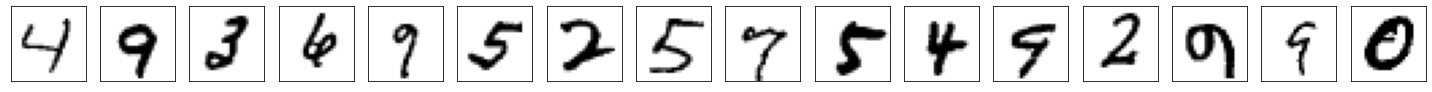

In [ ]:
fig = plt.figure(figsize=(20,5))
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(1, 16, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()    

### Implementing the discriminator and generator

Here, we are going to first define our *discriminator*. In our case, we will use an MLP, that will be responsible for receiving the images and trying to find which images are fake. The model is defined as follows 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        output = self.model(x)
        return output

To input the image coefficients into the MLP neural network, you vectorize them so that the neural network receives vectors with 784 coefficients. The vectorization occurs in the first line of `.forward()`, as the call to `x.view()` converts the shape of the input tensor. In this case, the original shape of the input x is 32 × 1 × 28 × 28, where 32 is the batch size you’ve set up. After the conversion, the shape of x becomes 32 × 784, with each line representing the coefficients of an image of the training set.

To run the discriminator model using the GPU, you have to instantiate it and send it to the GPU with .to(). To use a GPU when there’s one available, you can send the model to the device object you created earlier:

In [ ]:
discriminator = Discriminator().to(device=device)

Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space. In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image. Here is the complete generator model code:

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 784),  
        )


    def forward(self, x):
        #x = x.view(x.size(0), 100)
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [ ]:
generator = Generator().to(device=device)

As usual, we define the training hyper-parameters that will condition our learning procedure.

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
latent_space_samples_plot = torch.randn((16, 100)).to(device=device)

Epoch: 0 Loss D.: 0.5304396152496338
Epoch: 0 Loss G.: 0.5714701414108276


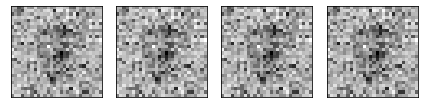

Epoch: 1 Loss D.: 0.18069559335708618
Epoch: 1 Loss G.: 5.790513515472412


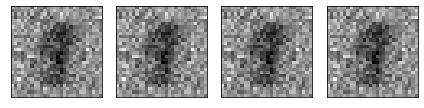

Epoch: 2 Loss D.: 0.14130571484565735
Epoch: 2 Loss G.: 4.499028205871582


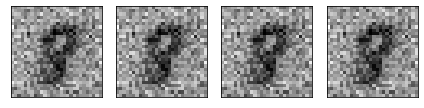

Epoch: 3 Loss D.: 0.040283579379320145
Epoch: 3 Loss G.: 5.2647385597229


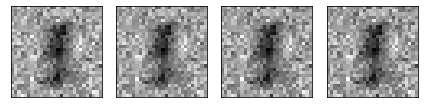

Epoch: 4 Loss D.: 0.12658539414405823
Epoch: 4 Loss G.: 3.0350594520568848


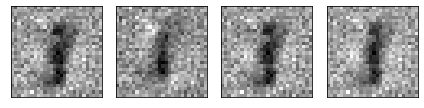

Epoch: 5 Loss D.: 0.1508438140153885
Epoch: 5 Loss G.: 3.443711280822754


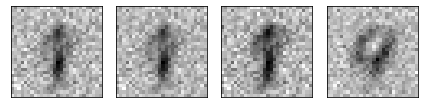

Epoch: 6 Loss D.: 0.08380338549613953
Epoch: 6 Loss G.: 3.687452793121338


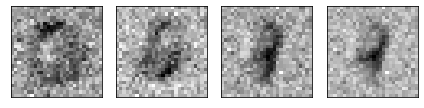

Epoch: 7 Loss D.: 0.19678695499897003
Epoch: 7 Loss G.: 3.5950982570648193


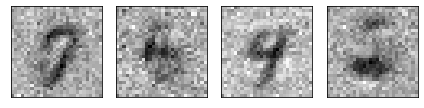

Epoch: 8 Loss D.: 0.2214459627866745
Epoch: 8 Loss G.: 3.428443431854248


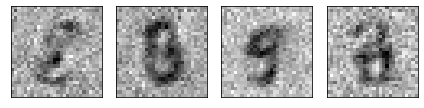

Epoch: 9 Loss D.: 0.32083991169929504
Epoch: 9 Loss G.: 2.5316824913024902


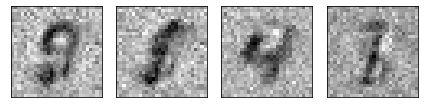

Epoch: 10 Loss D.: 0.342381089925766
Epoch: 10 Loss G.: 1.8841544389724731


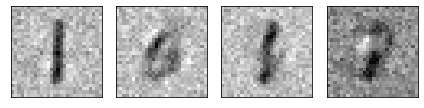

Epoch: 11 Loss D.: 0.3022126257419586
Epoch: 11 Loss G.: 1.9619736671447754


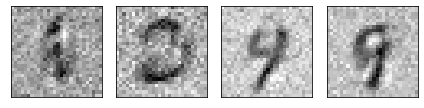

Epoch: 12 Loss D.: 0.3098437488079071
Epoch: 12 Loss G.: 1.854993224143982


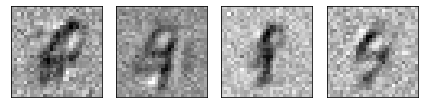

Epoch: 13 Loss D.: 0.4807462692260742
Epoch: 13 Loss G.: 1.9766985177993774


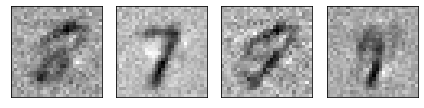

Epoch: 14 Loss D.: 0.4575461447238922
Epoch: 14 Loss G.: 1.5281102657318115


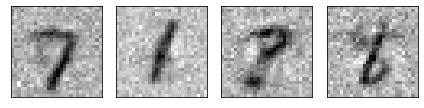

Epoch: 15 Loss D.: 0.39304429292678833
Epoch: 15 Loss G.: 1.9113155603408813


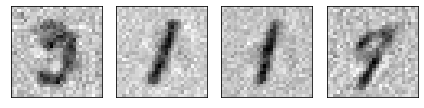

Epoch: 16 Loss D.: 0.45524996519088745
Epoch: 16 Loss G.: 1.745293378829956


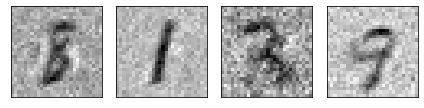

Epoch: 17 Loss D.: 0.5565869808197021
Epoch: 17 Loss G.: 1.473469853401184


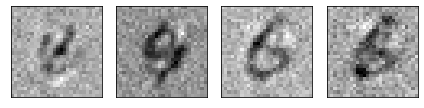

Epoch: 18 Loss D.: 0.34507226943969727
Epoch: 18 Loss G.: 1.7075159549713135


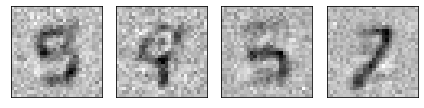

Epoch: 19 Loss D.: 0.543135941028595
Epoch: 19 Loss G.: 1.2199842929840088


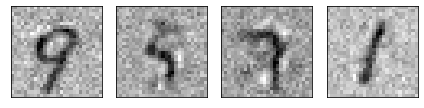

Epoch: 20 Loss D.: 0.522342324256897
Epoch: 20 Loss G.: 1.4775911569595337


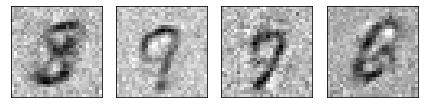

Epoch: 21 Loss D.: 0.4542083442211151
Epoch: 21 Loss G.: 1.5053807497024536


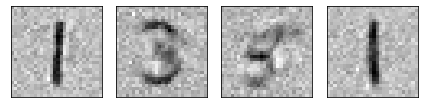

Epoch: 22 Loss D.: 0.4692835211753845
Epoch: 22 Loss G.: 1.2631030082702637


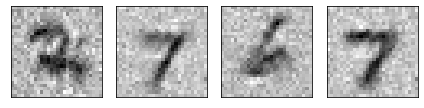

Epoch: 23 Loss D.: 0.41226398944854736
Epoch: 23 Loss G.: 1.430494785308838


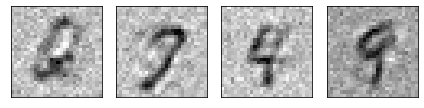

Epoch: 24 Loss D.: 0.3771815598011017
Epoch: 24 Loss G.: 1.7468868494033813


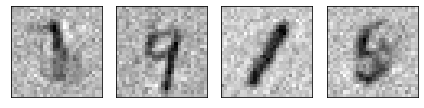

Epoch: 25 Loss D.: 0.4821937382221222
Epoch: 25 Loss G.: 1.5797381401062012


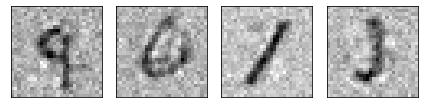

Epoch: 26 Loss D.: 0.47302860021591187
Epoch: 26 Loss G.: 1.4898427724838257


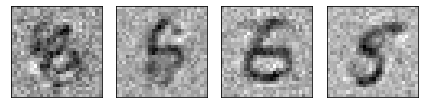

Epoch: 27 Loss D.: 0.33650684356689453
Epoch: 27 Loss G.: 1.5664050579071045


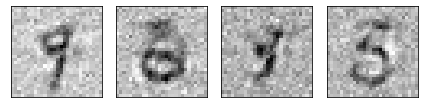

Epoch: 28 Loss D.: 0.3843238949775696
Epoch: 28 Loss G.: 1.3089115619659424


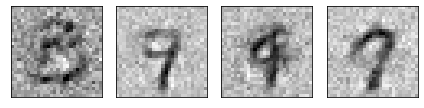

Epoch: 29 Loss D.: 0.2131052166223526
Epoch: 29 Loss G.: 1.8868236541748047


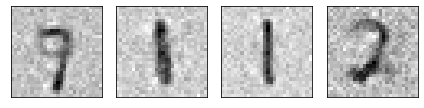

Epoch: 30 Loss D.: 0.4268017113208771
Epoch: 30 Loss G.: 1.3849414587020874


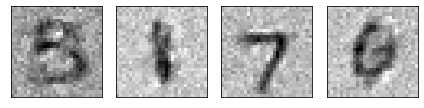

Epoch: 31 Loss D.: 0.39377257227897644
Epoch: 31 Loss G.: 1.875484585762024


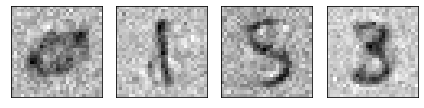

Epoch: 32 Loss D.: 0.2987084984779358
Epoch: 32 Loss G.: 1.497757911682129


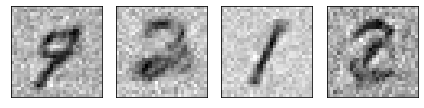

Epoch: 33 Loss D.: 0.3823257088661194
Epoch: 33 Loss G.: 1.6274683475494385


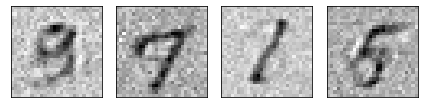

Epoch: 34 Loss D.: 0.3695142865180969
Epoch: 34 Loss G.: 1.5406885147094727


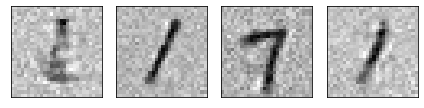

Epoch: 35 Loss D.: 0.33596283197402954
Epoch: 35 Loss G.: 1.8432745933532715


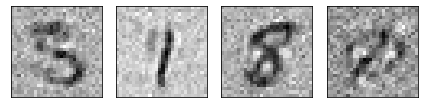

Epoch: 36 Loss D.: 0.3618260622024536
Epoch: 36 Loss G.: 1.8007991313934326


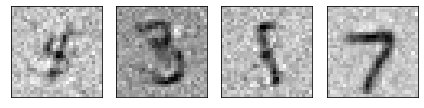

Epoch: 37 Loss D.: 0.43542200326919556
Epoch: 37 Loss G.: 1.743011713027954


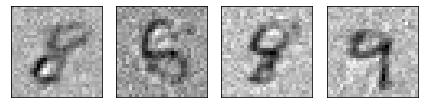

Epoch: 38 Loss D.: 0.41119420528411865
Epoch: 38 Loss G.: 2.2271265983581543


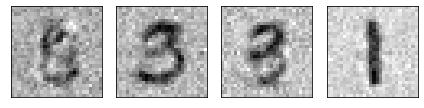

Epoch: 39 Loss D.: 0.43435582518577576
Epoch: 39 Loss G.: 2.4299118518829346


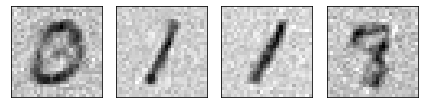

Epoch: 40 Loss D.: 0.30918076634407043
Epoch: 40 Loss G.: 2.009800434112549


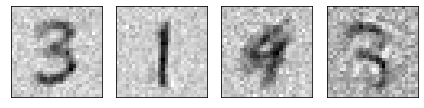

Epoch: 41 Loss D.: 0.3762568533420563
Epoch: 41 Loss G.: 1.909008264541626


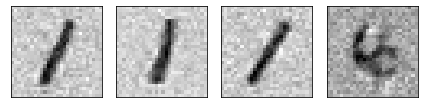

Epoch: 42 Loss D.: 0.3948446214199066
Epoch: 42 Loss G.: 1.644668459892273


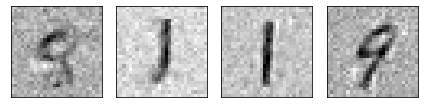

Epoch: 43 Loss D.: 0.4424421191215515
Epoch: 43 Loss G.: 1.8801226615905762


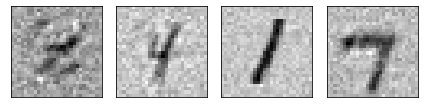

Epoch: 44 Loss D.: 0.43761351704597473
Epoch: 44 Loss G.: 2.1015784740448


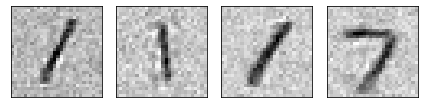

Epoch: 45 Loss D.: 0.35771235823631287
Epoch: 45 Loss G.: 1.7083868980407715


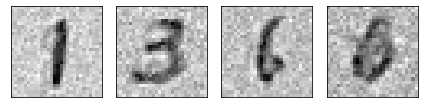

Epoch: 46 Loss D.: 0.3603535294532776
Epoch: 46 Loss G.: 1.6603074073791504


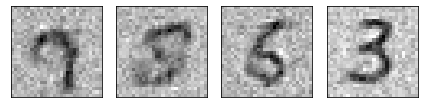

Epoch: 47 Loss D.: 0.35169970989227295
Epoch: 47 Loss G.: 1.6093546152114868


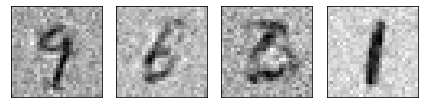

Epoch: 48 Loss D.: 0.35130295157432556
Epoch: 48 Loss G.: 1.8760006427764893


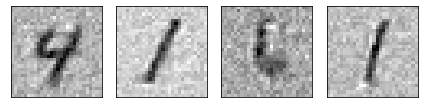

Epoch: 49 Loss D.: 0.30451011657714844
Epoch: 49 Loss G.: 2.184168577194214


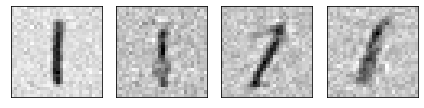

In [ ]:
# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in range(num_epochs):
        for n, (real_samples, mnist_labels) in enumerate(train_loader):
        
            ######################
            ## Discriminator
            optimizer_discriminator.zero_grad()
        
            # Génération fake samples 
            batch_size = real_samples.size(0)
            noise = torch.randn(batch_size, 100)
            fake_samples = generator(noise) # Forward generator

            # Forward discriminator 
            real_output = discriminator(real_samples)
            fake_output = discriminator(fake_samples)
            desired_real_dis = torch.ones_like(real_output)
            desired_fake_dis = torch.zeros_like(fake_output)
        
            # Loss discriminator
            loss_discriminator = loss_function(torch.concat((real_output, fake_output)), torch.concat((desired_real_dis, desired_fake_dis)))
            # Gradient discrimator 
            loss_discriminator.backward()  
        
            # update discriminator
            optimizer_discriminator.step()
        
        
            ## Generator 
            optimizer_generator.zero_grad()
        
            # Loss generator
            fake_samples = generator(noise)
            #fake_samples = fake_samples.cpu().detach()
            fake_ouput = discriminator(fake_samples)
            #desired_gen = torch.ones_like(fake_output)
            loss_generator = loss_function(fake_ouput, torch.ones_like(fake_output),)
                                           
            # Gradient generator 
            loss_generator.backward()  
        
            # update generator
            optimizer_generator.step()
            ######################

            # Show loss
            if n == batch_size - 1:
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")
                
                latent_space_samples = torch.randn(batch_size, 100)

                generated_samples = generator(latent_space_samples)
                generated_samples = generated_samples.cpu().detach()

                plt.figure()
                for i in range(4):
                    ax = plt.subplot(1, 4, i+1)
                    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                    plt.xticks([])
                    plt.yticks([])
                plt.tight_layout()
                plt.show()

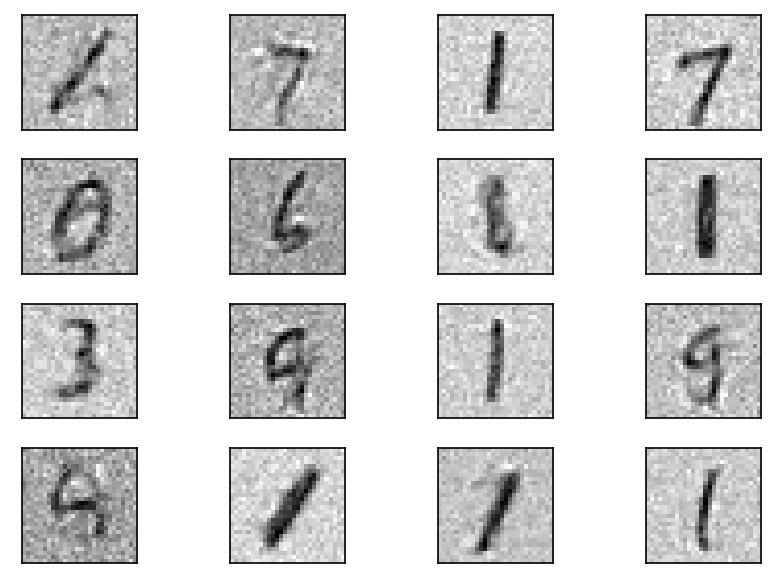

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

plt.figure(dpi=150)
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [ ]:
# Save trained NN parameters
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')